# Import necessary libraries 


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, sum, lit
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Create a spark Session

In [2]:
# Create a SparkSession
#spark = SparkSession.builder.appName("CA01_Sem_02").getOrCreate()

spark = SparkSession.builder.appName("CA01_Sem_02").config("spark.executor.memory", "12g").getOrCreate()

spark

PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

### Data_Ingestion function  - Load localy and save on Hadoop
 To leverage the use of hadoop,  this module was created to read the csv files into a pyspark dataframe and save on hadoop hdfs system

In [10]:

# data_ingestion function: Loads all CSV files in a directory using PySpark and saves them to a specified output path on HDFS.
# Args: 
    # path: Path to the directory containing CSV files  
    # hd_path: Hadoop path on HDFS to save the processed files

def data_ingestion( path, hd_path):
    
    try:
        # Read all files in the directory matching the CSV extension (*.csv)
        df = spark.read.csv(path, header=True, inferSchema = True)

        # Save the DataFrame to Hadoop server - HDFS
        df.write.mode("overwrite").csv(hd_path, header=True)
        print('Data Ingestion Completed')

    except Exception as e:
        print("An error occurred:", e)
    
    
    

# Running the data_ingestion function

In [14]:

# path to directory where the files are
path = "202301-capitalbikeshare-tripdata.csv"
# path where the files should be saved on hadoop
hd_path = "hdfs://192.168.56.101:9000/user1/teste_local/"



df = spark.read.csv(path, header=True, inferSchema = True)

# Call the processing function
data_ingestion(path, hd_path)


An error occurred: An error occurred while calling o119.csv.
: org.apache.hadoop.security.AccessControlException: Permission denied: user=JoseMario.Costa, access=WRITE, inode="/user1":hduser:supergroup:drwxr-xr-x
	at org.apache.hadoop.hdfs.server.namenode.FSPermissionChecker.check(FSPermissionChecker.java:506)
	at org.apache.hadoop.hdfs.server.namenode.FSPermissionChecker.checkPermission(FSPermissionChecker.java:346)
	at org.apache.hadoop.hdfs.server.namenode.FSPermissionChecker.checkPermissionWithContext(FSPermissionChecker.java:370)
	at org.apache.hadoop.hdfs.server.namenode.FSPermissionChecker.checkPermission(FSPermissionChecker.java:240)
	at org.apache.hadoop.hdfs.server.namenode.FSDirectory.checkPermission(FSDirectory.java:1943)
	at org.apache.hadoop.hdfs.server.namenode.FSDirectory.checkPermission(FSDirectory.java:1927)
	at org.apache.hadoop.hdfs.server.namenode.FSDirectory.checkAncestorAccess(FSDirectory.java:1886)
	at org.apache.hadoop.hdfs.server.namenode.FSDirMkdirOp.mkdirs(F

# Load data from hadoop

In [2]:
!pyspark

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.
The system cannot find the path specified.
The system cannot find the path specified.


In [5]:

hd_path = "hdfs://192.168.56.101:9000/user1/CarPrice_Assignment.csv"

try:
   

  # Read the CSV files using the specified path
  df = spark.read.csv(hd_path, header = True, inferSchema = True)

  # Print the first few rows of the DataFrame (optional)
  df.show(2)

   
except Exception as e:
    print("An error occurred:", str(e))


An error occurred: An error occurred while calling o32.csv.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 0.0 failed 1 times, most recent failure: Lost task 0.0 in stage 0.0 (TID 0) (IE-DUB1-LAP-018.brownelogistics.local executor driver): org.apache.spark.SparkException: Encountered error while reading file hdfs://192.168.56.101:9000/user1/CarPrice_Assignment.csv. Details:
	at org.apache.spark.sql.errors.QueryExecutionErrors$.cannotReadFilesError(QueryExecutionErrors.scala:863)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:293)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java

# Loading data localy 
    In case of hadoop is unavailable

In [5]:
ls

 Volume in drive C has no label.
 Volume Serial Number is D689-872F

 Directory of c:\Users\josemario.Costa\OneDrive\CCT\MsC_Data_Analytics\CA01_Sem_02_MSc_Data_Analytics

20/03/2024  11:33    <DIR>          .
08/03/2024  22:58    <DIR>          ..
20/03/2024  10:38    <DIR>          .git
19/03/2024  09:32               111 .gitignore
15/03/2024  10:53    <DIR>          .ipynb_checkpoints
13/03/2024  16:30        40,817,886 202301-capitalbikeshare-tripdata.csv
13/03/2024  16:30        41,557,668 202302-captialbikeshare-tripdata.csv
13/03/2024  16:30        58,127,568 202303-capitalbikeshare-tripdata.csv
13/03/2024  16:30        77,469,016 202304-capitalbikeshare-tripdata.csv
13/03/2024  16:30        85,942,204 202305-capitalbikeshare-tripdata.csv
13/03/2024  16:30        85,406,857 202306-capitalbikeshare-tripdata.csv
13/03/2024  16:30        92,502,758 202307-capitalbikeshare-tripdata.csv
13/03/2024  16:30        93,045,620 202308-capitalbikeshare-tripdata.csv
13/03/2024  16:30       

In [7]:
# path to directory where the files are

df = spark.read.csv("202301-capitalbikeshare-tripdata.csv", header=True, inferSchema = True)


In [4]:
df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



### Checking the shape of the dataframe\


In [5]:
print((df.count(), len(df.columns)))

(204077, 13)


When it comes to using RNNs for time series forecasting or analysis, the data structure must have some level of consistency, as each row of the dataset represents one trip, only  a new column was created to represent the tripa and only  date and trips were selected from the dataset

In [6]:
trips = df.select("started_at")

In [7]:
trips = trips.withColumn("trips", lit(1))

In [8]:
trips.show(3)

+-------------------+-----+
|         started_at|trips|
+-------------------+-----+
|2023-01-04 19:34:07|    1|
|2023-01-27 15:26:38|    1|
|2023-01-05 20:44:38|    1|
+-------------------+-----+
only showing top 3 rows



In [9]:
trips.printSchema()

root
 |-- started_at: timestamp (nullable = true)
 |-- trips: integer (nullable = false)



In [10]:
window_spec = window(trips['started_at'], "1 day")
daily_df = trips.groupBy(window_spec).agg(sum("trips").alias("total_trips"))


In [11]:
daily_df = daily_df.orderBy("window")

In [12]:
daily_df.show(10)

+--------------------+-----------+
|              window|total_trips|
+--------------------+-----------+
|{2023-01-01 00:00...|       6787|
|{2023-01-02 00:00...|       7240|
|{2023-01-03 00:00...|       7559|
|{2023-01-04 00:00...|       7791|
|{2023-01-05 00:00...|       8409|
|{2023-01-06 00:00...|       6719|
|{2023-01-07 00:00...|       7122|
|{2023-01-08 00:00...|       5176|
|{2023-01-09 00:00...|       6520|
|{2023-01-10 00:00...|       7303|
+--------------------+-----------+
only showing top 10 rows



In [13]:
daily_df.describe().show()

+-------+------------------+
|summary|       total_trips|
+-------+------------------+
|  count|                31|
|   mean| 6583.129032258064|
| stddev|1224.3107650683976|
|    min|              4001|
|    max|              8712|
+-------+------------------+



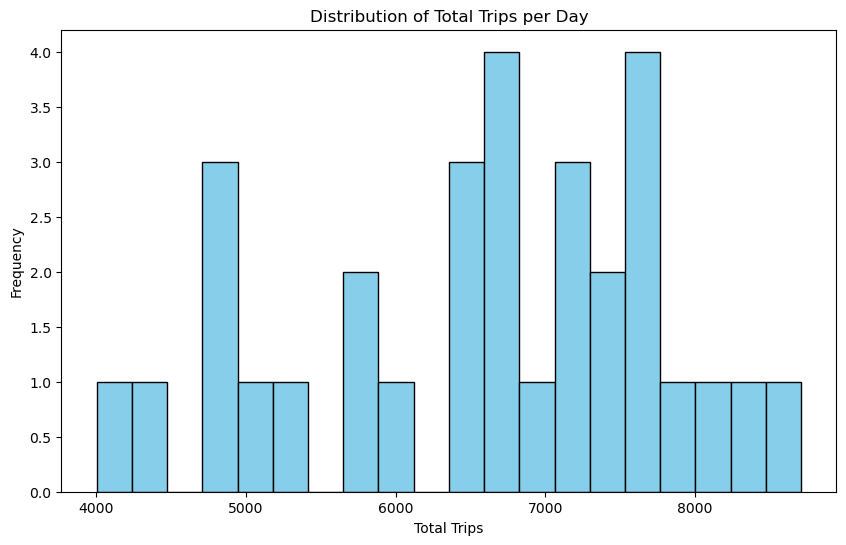

In [14]:
# Converting PySpark DataFrame to Pandas DataFrame
pandas_df = daily_df.toPandas()

# Plotting a histogram
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['total_trips'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Trips per Day')
plt.xlabel('Total Trips')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


In [48]:
trips = pandas_df.iloc[:,-1]

In [49]:
type(trips)

pandas.core.series.Series

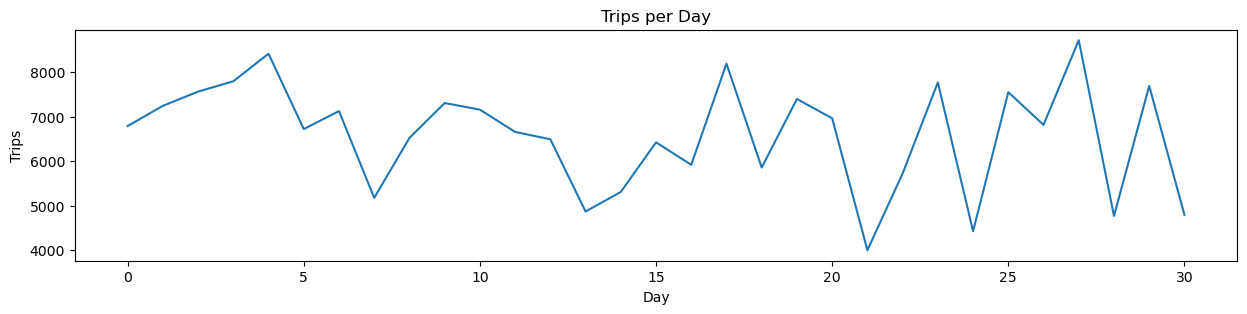

In [50]:
plt.figure(figsize=(15, 3))

trips.plot(kind='line') 

plt.title("Trips per Day")
plt.xlabel("Day")
plt.ylabel("Trips")
plt.grid(False)
plt.show()

# LSTM 


TensorFlow is designed to work primarily with NumPy arrays. Because of this, pandas.core.series will be transform into NumPy arrays.

In [56]:
# convert to numpy array

np_trips = trips.to_numpy()
np_trips = np_trips.reshape(-1,1)
type(np_trips)

numpy.ndarray

# Normalize the data,  the recommended scaler for LSTM is  MinMaxScaler in a range of 0,1

In [59]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
np_trips = scaler.fit_transform(np_trips)

In [60]:
# split into train and test sets
train_size = int(len(np_trips) * 0.8)
test_size = len(np_trips) - train_size
train, test = np_trips[0:train_size,:], np_trips[train_size:len(np_trips),:]


The next thing we need to do is to specify our number of timesteps. Timesteps specify how many previous observations should be considered when the recurrent neural network makes a prediction about the current observation.
We will use 7 (week based) timesteps. This means that for every day that the neural network predicts, it will consider the previous 7 days of trips to determine its output. 


In [64]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [65]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [66]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [67]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
22/22 - 1s - 56ms/step - loss: 0.3904
Epoch 2/100
22/22 - 0s - 5ms/step - loss: 0.3453
Epoch 3/100
22/22 - 0s - 3ms/step - loss: 0.3072
Epoch 4/100
22/22 - 0s - 5ms/step - loss: 0.2707
Epoch 5/100
22/22 - 0s - 11ms/step - loss: 0.2373
Epoch 6/100
22/22 - 0s - 2ms/step - loss: 0.2081
Epoch 7/100
22/22 - 0s - 2ms/step - loss: 0.1810
Epoch 8/100
22/22 - 0s - 2ms/step - loss: 0.1567
Epoch 9/100
22/22 - 0s - 2ms/step - loss: 0.1356
Epoch 10/100
22/22 - 0s - 2ms/step - loss: 0.1184
Epoch 11/100
22/22 - 0s - 2ms/step - loss: 0.1017
Epoch 12/100
22/22 - 0s - 2ms/step - loss: 0.0889
Epoch 13/100
22/22 - 0s - 2ms/step - loss: 0.0798
Epoch 14/100
22/22 - 0s - 2ms/step - loss: 0.0710
Epoch 15/100
22/22 - 0s - 2ms/step - loss: 0.0650
Epoch 16/100
22/22 - 0s - 2ms/step - loss: 0.0612
Epoch 17/100
22/22 - 0s - 2ms/step - loss: 0.0572
Epoch 18/100
22/22 - 0s - 2ms/step - loss: 0.0552
Epoch 19/100
22/22 - 0s - 2ms/step - loss: 0.0533
Epoch 20/100
22/22 - 0s - 2ms/step - loss: 0.0523
Epoch 2

In [68]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [69]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [70]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 1053.06 RMSE
Test Score: 1638.35 RMSE


In [72]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(np_trips)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [74]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(np_trips)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(np_trips)-1, :] = testPredict

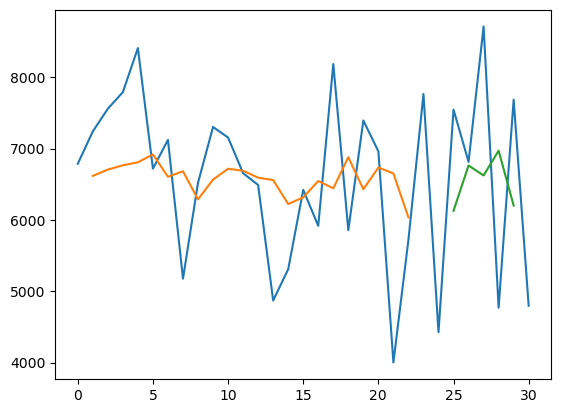

In [75]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(np_trips))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()